In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [14]:
# Additional utility functions for model improvement
def compare_models(predictor):
    """Compare Linear Regression with Random Forest"""
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)

    # Train Random Forest for comparison
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(predictor.X_train, predictor.y_train)

    # Predictions
    lr_pred = predictor.model.predict(predictor.X_test_scaled)
    rf_pred = rf_model.predict(predictor.X_test)

    # Metrics
    lr_r2 = r2_score(predictor.y_test, lr_pred)
    rf_r2 = r2_score(predictor.y_test, rf_pred)
    lr_rmse = np.sqrt(mean_squared_error(predictor.y_test, lr_pred))
    rf_rmse = np.sqrt(mean_squared_error(predictor.y_test, rf_pred))

    print(f"Linear Regression - R²: {lr_r2:.4f}, RMSE: {lr_rmse:.2f}")
    print(f"Random Forest - R²: {rf_r2:.4f}, RMSE: {rf_rmse:.2f}")

    return {'lr_r2': lr_r2, 'rf_r2': rf_r2, 'lr_rmse': lr_rmse, 'rf_rmse': rf_rmse}

In [15]:
class SuperstoreSalesPredictor:
    def __init__(self, csv_file_path):
        """
        Initialize the sales predictor with data loading and preprocessing
        """
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_names = []

        # Load and preprocess data
        self.load_data(csv_file_path)
        self.preprocess_data()

    def load_data(self, csv_file_path):
        """Load the Superstore dataset"""
        try:
            self.df = pd.read_csv(csv_file_path)
            print(f"Dataset loaded successfully!")
            print(f"Shape: {self.df.shape}")
            print(f"Columns: {list(self.df.columns)}")
        except FileNotFoundError:
            print(f"File not found: {csv_file_path}")
            print("Please ensure the file path is correct.")
            return None

    def explore_data(self):
        """Perform basic exploratory data analysis"""
        print("\n" + "="*50)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*50)

        # Basic info
        print("\nDataset Info:")
        print(self.df.info())

        print("\nFirst 5 rows:")
        print(self.df.head())

        print("\nSales Statistics:")
        print(self.df['Sales'].describe())

        # Check for missing values
        print("\nMissing Values:")
        print(self.df.isnull().sum())

        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Sales distribution
        axes[0, 0].hist(self.df['Sales'], bins=50, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Distribution of Sales')
        axes[0, 0].set_xlabel('Sales')
        axes[0, 0].set_ylabel('Frequency')

        # Sales by Category
        sales_by_category = self.df.groupby('Category')['Sales'].mean().sort_values(ascending=False)
        axes[0, 1].bar(sales_by_category.index, sales_by_category.values, color='lightcoral')
        axes[0, 1].set_title('Average Sales by Category')
        axes[0, 1].set_xlabel('Category')
        axes[0, 1].set_ylabel('Average Sales')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Sales by Region
        sales_by_region = self.df.groupby('Region')['Sales'].mean().sort_values(ascending=False)
        axes[1, 0].bar(sales_by_region.index, sales_by_region.values, color='lightgreen')
        axes[1, 0].set_title('Average Sales by Region')
        axes[1, 0].set_xlabel('Region')
        axes[1, 0].set_ylabel('Average Sales')

        # Sales by Segment
        sales_by_segment = self.df.groupby('Segment')['Sales'].mean().sort_values(ascending=False)
        axes[1, 1].bar(sales_by_segment.index, sales_by_segment.values, color='gold')
        axes[1, 1].set_title('Average Sales by Segment')
        axes[1, 1].set_xlabel('Segment')
        axes[1, 1].set_ylabel('Average Sales')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocess the data for modeling"""
        if self.df is None:
            print("No data loaded. Please load data first.")
            return

        print("\n" + "="*50)
        print("DATA PREPROCESSING")
        print("="*50)

        # Create a copy for preprocessing
        df_processed = self.df.copy()

        # Convert date columns
        df_processed['Order Date'] = pd.to_datetime(df_processed['Order Date'], dayfirst=True, errors='coerce')
        df_processed['Ship Date'] = pd.to_datetime(df_processed['Ship Date'], dayfirst=True, errors='coerce')

        # Create new features from dates
        df_processed['Order Year'] = df_processed['Order Date'].dt.year
        df_processed['Order Month'] = df_processed['Order Date'].dt.month
        df_processed['Order Quarter'] = df_processed['Order Date'].dt.quarter
        df_processed['Order Day of Week'] = df_processed['Order Date'].dt.dayofweek
        df_processed['Shipping Days'] = (df_processed['Ship Date'] - df_processed['Order Date']).dt.days

        # Select categorical features to encode
        categorical_features = ['Ship Mode', 'Segment', 'Category', 'Sub-Category', 'Region']

        # Encode categorical variables
        for feature in categorical_features:
            if feature in df_processed.columns:
                le = LabelEncoder()
                df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature])
                self.label_encoders[feature] = le

        # Select features for modeling
        feature_columns = [
            'Order Year', 'Order Month', 'Order Quarter', 'Order Day of Week', 'Shipping Days',
            'Ship Mode_encoded', 'Segment_encoded', 'Category_encoded',
            'Sub-Category_encoded', 'Region_encoded'
        ]

        # Remove rows with missing values in key columns
        df_processed = df_processed.dropna(subset=feature_columns + ['Sales'])

        # Prepare features and target
        X = df_processed[feature_columns]
        y = df_processed['Sales']

        self.feature_names = feature_columns

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=None
        )

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"Training set size: {self.X_train.shape[0]}")
        print(f"Test set size: {self.X_test.shape[0]}")
        print(f"Features used: {self.feature_names}")

    def train_model(self):
        """Train the linear regression model"""
        print("\n" + "="*50)
        print("MODEL TRAINING")
        print("="*50)

        # Initialize and train the model
        self.model = LinearRegression()
        self.model.fit(self.X_train_scaled, self.y_train)

        print("Linear Regression model trained successfully!")

        # Display feature coefficients
        feature_importance = pd.DataFrame({
            'Feature': self.feature_names,
            'Coefficient': self.model.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)

        print("\nFeature Coefficients (sorted by absolute value):")
        print(feature_importance)

        return self.model

    def evaluate_model(self):
        """Evaluate the model performance"""
        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        # Make predictions
        y_train_pred = self.model.predict(self.X_train_scaled)
        y_test_pred = self.model.predict(self.X_test_scaled)

        # Calculate metrics
        train_mse = mean_squared_error(self.y_train, y_train_pred)
        test_mse = mean_squared_error(self.y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(self.y_train, y_train_pred)
        test_mae = mean_absolute_error(self.y_test, y_test_pred)
        train_r2 = r2_score(self.y_train, y_train_pred)
        test_r2 = r2_score(self.y_test, y_test_pred)

        # Print metrics
        print("Performance Metrics:")
        print(f"{'Metric':<15} {'Training':<12} {'Testing':<12}")
        print("-" * 40)
        print(f"{'R² Score':<15} {train_r2:<12.4f} {test_r2:<12.4f}")
        print(f"{'RMSE':<15} {train_rmse:<12.2f} {test_rmse:<12.2f}")
        print(f"{'MAE':<15} {train_mae:<12.2f} {test_mae:<12.2f}")
        print(f"{'MSE':<15} {train_mse:<12.2f} {test_mse:<12.2f}")

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Actual vs Predicted scatter plot
        axes[0].scatter(self.y_test, y_test_pred, alpha=0.6, color='blue')
        axes[0].plot([self.y_test.min(), self.y_test.max()],
                     [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Sales')
        axes[0].set_ylabel('Predicted Sales')
        axes[0].set_title(f'Actual vs Predicted Sales\nR² = {test_r2:.4f}')

        # Residuals plot
        residuals = self.y_test - y_test_pred
        axes[1].scatter(y_test_pred, residuals, alpha=0.6, color='green')
        axes[1].axhline(y=0, color='r', linestyle='--')
        axes[1].set_xlabel('Predicted Sales')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residuals Plot')

        # Feature importance plot
        feature_importance = pd.DataFrame({
            'Feature': self.feature_names,
            'Coefficient': np.abs(self.model.coef_)
        }).sort_values('Coefficient', ascending=True)

        axes[2].barh(feature_importance['Feature'], feature_importance['Coefficient'])
        axes[2].set_xlabel('Absolute Coefficient Value')
        axes[2].set_title('Feature Importance')

        plt.tight_layout()
        plt.show()

        return {
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'predictions': y_test_pred
        }

    def predict_new_sales(self, new_data_dict):
        """Make predictions on new data"""
        print("\n" + "="*50)
        print("MAKING PREDICTIONS")
        print("="*50)

        # Create DataFrame from input dictionary
        new_df = pd.DataFrame([new_data_dict])

        # Encode categorical variables
        for feature in ['Ship Mode', 'Segment', 'Category', 'Sub-Category', 'Region']:
            if feature in new_data_dict:
                if feature in self.label_encoders:
                    try:
                        encoded_value = self.label_encoders[feature].transform([new_data_dict[feature]])[0]
                        new_df[f'{feature}_encoded'] = encoded_value
                    except ValueError:
                        print(f"Warning: '{new_data_dict[feature]}' not seen during training for {feature}")
                        new_df[f'{feature}_encoded'] = 0  # Default to 0

        # Select features in the same order as training
        X_new = new_df[self.feature_names]

        # Scale the new data
        X_new_scaled = self.scaler.transform(X_new)

        # Make prediction
        prediction = self.model.predict(X_new_scaled)[0]

        print(f"Input data: {new_data_dict}")
        print(f"Predicted Sales: ${prediction:.2f}")

        return prediction

Dataset loaded successfully!
Shape: (9800, 18)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales']

DATA PREPROCESSING
Training set size: 7840
Test set size: 1960
Features used: ['Order Year', 'Order Month', 'Order Quarter', 'Order Day of Week', 'Shipping Days', 'Ship Mode_encoded', 'Segment_encoded', 'Category_encoded', 'Sub-Category_encoded', 'Region_encoded']

EXPLORATORY DATA ANALYSIS

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   obj

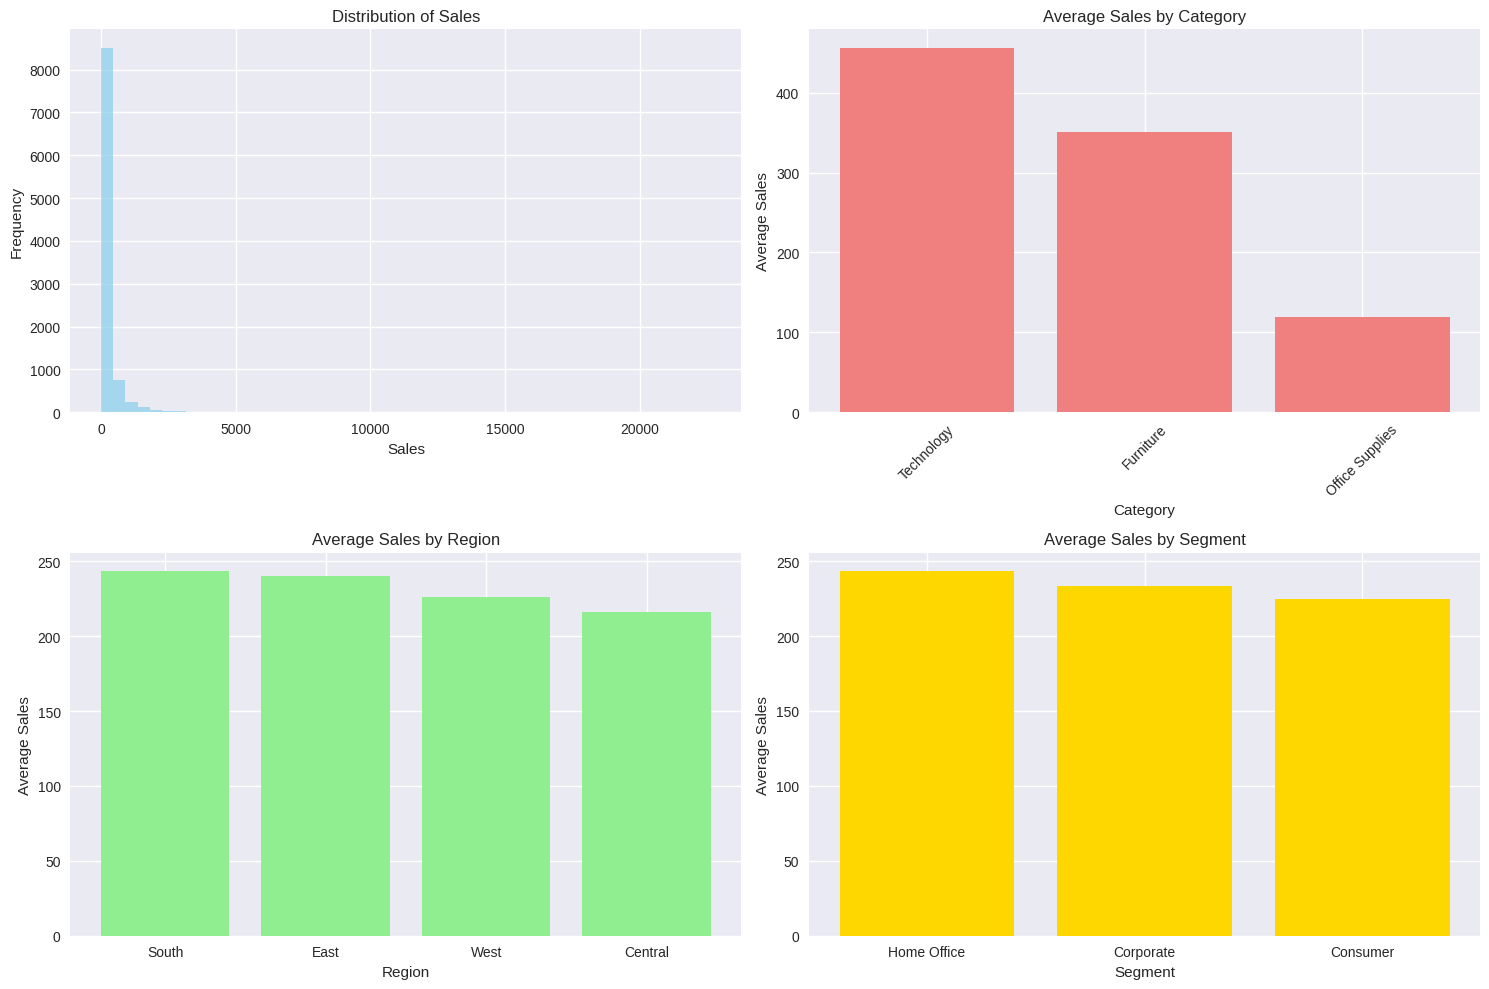


MODEL TRAINING
Linear Regression model trained successfully!

Feature Coefficients (sorted by absolute value):
                Feature  Coefficient
8  Sub-Category_encoded    34.319693
7      Category_encoded    20.248854
1           Order Month     5.420134
0            Order Year    -3.932454
4         Shipping Days    -3.058216
2         Order Quarter    -2.302947
9        Region_encoded     2.053965
6       Segment_encoded     1.491846
3     Order Day of Week    -0.901328
5     Ship Mode_encoded     0.119806

MODEL EVALUATION
Performance Metrics:
Metric          Training     Testing     
----------------------------------------
R² Score        0.0047       0.0041      
RMSE            567.21       815.89      
MAE             253.20       300.77      
MSE             321724.82    665678.68   


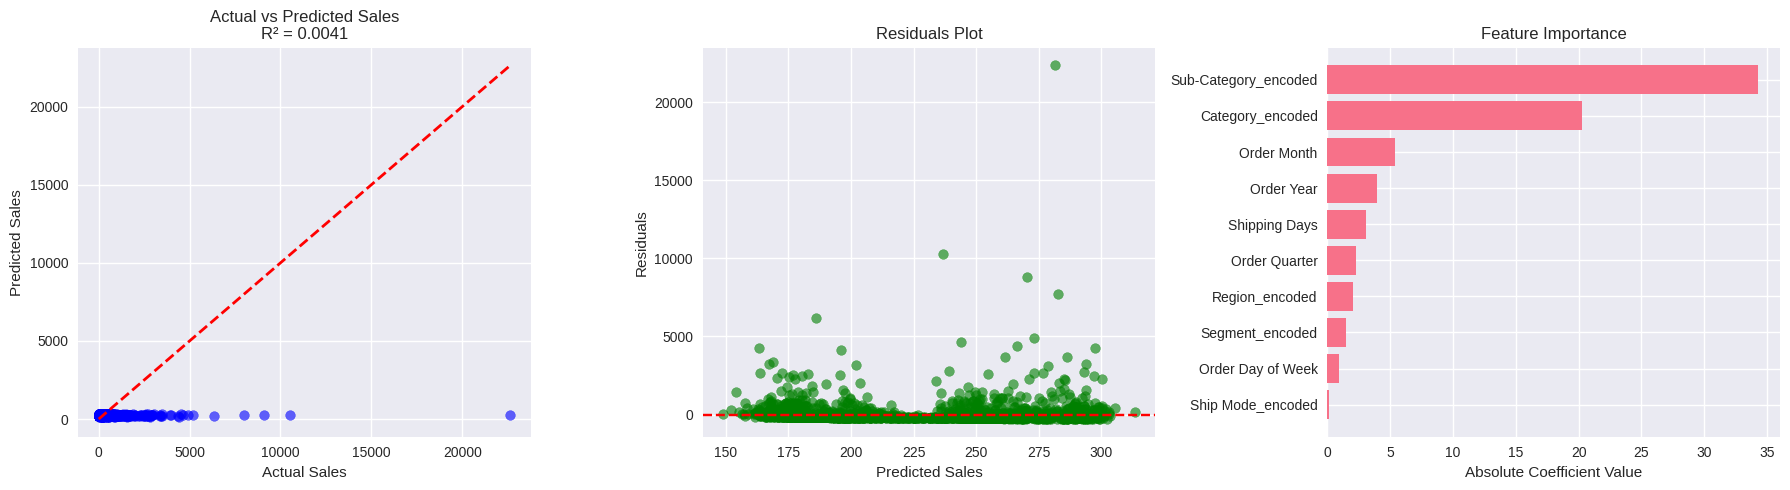


MODEL COMPARISON
Linear Regression - R²: 0.0041, RMSE: 815.89
Random Forest - R²: 0.0034, RMSE: 816.16

MAKING PREDICTIONS
Input data: {'Order Year': 2023, 'Order Month': 12, 'Order Quarter': 4, 'Order Day of Week': 1, 'Shipping Days': 3, 'Ship Mode': 'Standard Class', 'Segment': 'Consumer', 'Category': 'Technology', 'Sub-Category': 'Phones', 'Region': 'West'}
Predicted Sales: $277.20


In [16]:
def main():
    # Initialize the predictor
    predictor = SuperstoreSalesPredictor('data/superstore.csv')
    predictor.explore_data()          # Data exploration
    predictor.train_model()           # Train the model
    results = predictor.evaluate_model()  # Evaluate performance

    # compare with Random Forest
    comparison_results = compare_models(predictor)

    prediction = predictor.predict_new_sales({
      'Order Year': 2023,
      'Order Month': 12,
      'Order Quarter': 4,
      'Order Day of Week': 1,
      'Shipping Days': 3,
      'Ship Mode': 'Standard Class',
      'Segment': 'Consumer',
      'Category': 'Technology',
      'Sub-Category': 'Phones',
      'Region': 'West'
    })

if __name__ == "__main__":
    main()